# **Clustering**

### import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import skfuzzy as fuzz
from fcmeans import FCM
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score

### reading csv files

In [2]:
df1 = pd.read_csv('first_clustering_dataset.csv', header = None)
df2 = pd.read_csv('second_clustering_dataset.csv', header = None)
df3 = pd.read_csv('third_clustering_dataset.csv', header = None)

### put dataset records into the numpy arrays

In [3]:
X1 = df1.values
X2 = df2.values
X3 = df3.values

### scale data using standard scaling

In [4]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X3 = scaler.fit_transform(X3)

In [5]:
df1.columns

Int64Index([0, 1], dtype='int64')

### calculating shape of dataset

In [6]:
print("shape of df1 is: ", df1.shape)
print("shape of df2 is: ",df2.shape)
print("shape of df3 is: ",df3.shape)

shape of df1 is:  (400, 2)
shape of df2 is:  (450, 2)
shape of df3 is:  (500, 2)


# visualizing each dataset in 2d plots and analyze them

### first dataset

<AxesSubplot:xlabel='0', ylabel='1'>

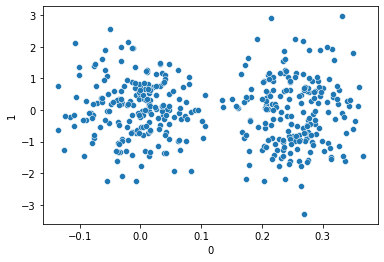

In [7]:
sns.scatterplot(data=df1, x=0, y=1)

Roughly speaking, it's better not to use DBSCAN because the DBSCAN algorithm separates data points with higher density from those with lower density into different clusters. Another point to consider is that we have determined the number of clusters from the data, so it's better to use two other algorithms (K-means and FCM). Based on the plot, since our clusters do not overlap, it's better to use the K-means algorithm for clustering. Of course, using FCM is also acceptable. Moving forward, for each dataset, we will run three algorithms and display the results with numbers.

### second dataset

<AxesSubplot:xlabel='0', ylabel='1'>

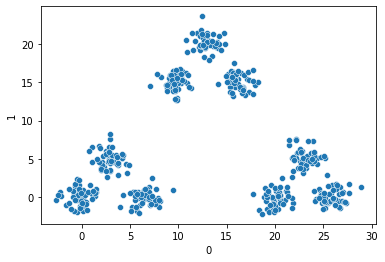

In [8]:
sns.scatterplot(data=df2, x=0, y=1)

In this dataset, the number of clusters can be either 3 or 9. We will choose 9 for our clustering. Given that the clusters are quite dense and have reasonable separation, the K-means algorithm is the best option, and using the DBSCAN algorithm is also acceptable since there are not many outliers, and it performs well in categorization.

### third dataset

<AxesSubplot:xlabel='0', ylabel='1'>

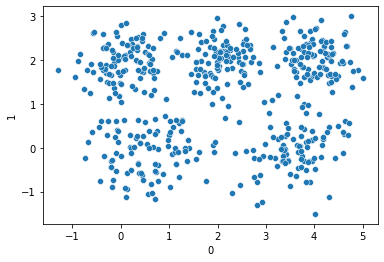

In [9]:
sns.scatterplot(data=df3, x=0, y=1)

According to the plot, it can be said that the optimal number of clusters is 5. Since some clusters are denser, DBSCAN can be helpful, but because there are many outliers, it's better not to use DBSCAN. The K-means and FCM algorithms are our best choices. K-means may work well, and considering that our clusters may overlap, using FCM might be a better option.

### defining functions

The `drawElbowMethodPlot` function, when executed with the algorithm, helps us find the optimal number of clusters by analyzing the plot. Wherever the plot breaks, that number represents the best choice for the cluster count. The algorithm is run 200 times, each time performing up to 300 iterations, and finally, the best result is presented.

In [10]:
def drawElbowMethodPlot(df):
    wcss = []
    for i in range(1, 16):
        model = KMeans(n_clusters = i, init = 'random', n_init = 200, random_state=42)                   
        model.fit(df)   
        wcss.append(model.inertia_)

    plt.plot(range(1, 16), wcss)
    plt.title('Elbow Method')                     
    plt.xlabel('Number of clusters')                       
    plt.ylabel('wcss')   
    plt.show()

The `kmeansAndPlot` function clusters the data using the K-means algorithm, assigns colors to the data points based on the assigned labels, and displays the locations of the centroids in red. Additionally, it calculates the sum of squared distances (SSE), which represents the sum of squared distances between data points and their respective centroids, and returns this value. A lower SSE indicates a better-fitting model.

In [11]:
def kmeansAndPlot(n_clusters, X):
    kmeans = KMeans(n_clusters = n_clusters, init = 'random', n_init = 200, random_state=42)             
    y_pred= kmeans.fit_predict(X)

    plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)

    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')   
    plt.title("Kmeans")
    plt.show()
    print("the SSE is: ", kmeans.inertia_)

The `find_eps` function, when provided with an approximate value of neighbors, returns the best radius (eps) value.

In [12]:
def find_eps(X, n_nei):
    nearest_neighbors = NearestNeighbors(n_neighbors=n_nei)
    neighbors = nearest_neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    distances = np.sort(distances[:,n_nei-1], axis=0)

    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    fig = plt.figure(figsize=(5, 5))
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")
    print(distances[knee.knee])

The `get_dbscan_score` function, given an eps value and a range of neighbor counts between 2 and 30, returns the best number of points (min_samples) by calculating the Silhouette score.

In [13]:
def get_min_samples(data, eps):
    centers = list(range(2,30))
    scores = []
    
    for center in centers:
        dbscan = DBSCAN(eps= eps, min_samples=center)
        model = dbscan.fit(data)
        score = silhouette_score(data, model.labels_, metric='euclidean')
        scores.append(score)

    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('min_samples');
    plt.ylabel('Silhouette Score');

    df_min = pd.DataFrame(centers,columns=['min_samples'])
    df_min['scores'] = scores
    df_sil = df_min[df_min.scores == df_min.scores.max()]
    print('Optimal number of min_samples based on silhouette score:', df_sil['min_samples'].tolist())

The `dbscan` function, given eps and min_samples, labels each data point into the desired cluster and finally displays the Silhouette Coefficient. A value closer to 1 indicates a better model for clustering.

In [14]:
def dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    labels = db.labels_
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

The `fcmCluster` function uses the fuzzy c-means algorithm, taking the number of clusters, to cluster the data and finally returns the partition coefficient. A value closer to 1 indicates a better model. In the end, it displays the points that belong to more than 2 clusters.

In [15]:
def fcmCluster(X, n_clusters):
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(X)
    fcm_centers = fcm.centers
    fcm_labels = fcm.predict(X)
    print("the partition coefficient is: %0.3f" %fcm.partition_coefficient)

    f, axes = plt.subplots()
    axes.scatter(X[:,0], X[:,1], c=fcm_labels)
    axes.scatter(fcm_centers[:,0], fcm_centers[:,1], marker="o", s=100, c='r')

The function displays the points in the FCM algorithm that belong to more than 2 clusters.

In [62]:
def fcmCluster2(X, n_clusters):
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(X)
    fcm_centers = fcm.centers
    fcm_labels_soft = fcm.soft_predict(X)
    fcm_labels = fcm.predict(X)
    print("the partition coefficient is: %0.3f" %fcm.partition_coefficient)
    
    data_more_2_clusters = []
    for i in range(X.shape[0]):
        c = 0
        for j in range(n_clusters):
            if ( fcm_labels_soft[i][j]> 0.2):
                c+=1
        if c>2:
            data_more_2_clusters.append(X[i])
    data_more_2_clusters = np.array(data_more_2_clusters)
    

    f, axes = plt.subplots()
    axes.scatter(X[:,0], X[:,1], c=fcm_labels)
    axes.scatter(fcm_centers[:,0], fcm_centers[:,1], marker="o", s=100, c='r')
    axes.scatter(data_more_2_clusters[:, 0], data_more_2_clusters[:, 1],marker="s", c= 'r')

the partition coefficient is: 0.136


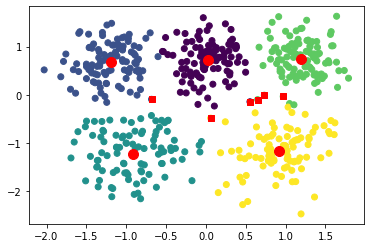

In [63]:
fcmCluster2(X3, 5)

#### The three functions below execute each algorithm 200 times, and finally, they display the best algorithm based on the error and obtained coefficients.

## 1-Kmeans

In [17]:
def run_200_kmeans_get_err(X, n_clusters):
    scores = []
    for _ in range(200):
        kmeans = KMeans(n_clusters = n_clusters, init = 'random', n_init = 200, random_state=42)             
        y_pred= kmeans.fit_predict(X)
        scores.append(kmeans.inertia_)
    return min(scores)

## 2- DBSCAN

In [18]:
def run_200_dbscan_get_err(X, eps, min_samples):
    scores = []
    for _ in range(200):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(X)
        y_pred = db.fit_predict(X)
        labels = db.labels_
        scores.append(silhouette_score(X, labels))
    return max(scores)

## 3-FCM

In [19]:
def run_200_fcm_get_err(X, n_clusters):
    scores = []
    for _ in range(200):
        fcm = FCM(n_clusters=n_clusters)
        fcm.fit(X)
        fcm_centers = fcm.centers
        fcm_labels = fcm.predict(X)
        scores.append(fcm.partition_coefficient)
    return max(scores)

Now we run the algorithms for each dataset and observe the results:

## Running 3 clustering algorithms for the first dataset

### Kmeans

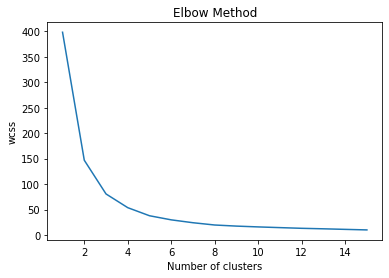

In [20]:
drawElbowMethodPlot(df1)

Using the `drawElbowMethodPlot` function, we realize that the best number for the cluster count is 2 because the plot breaks at that point.

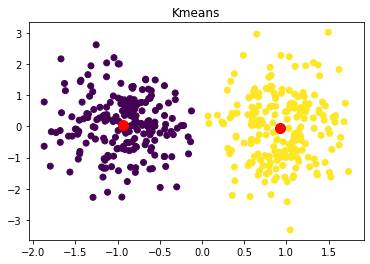

the SSE is:  452.60628960519114


In [21]:
kmeansAndPlot(2, X1)

We run the `kmeansAndPlot` function, and you can see the display above. As you can observe, the data has been clustered well into 2 clusters, and the SSE (sum of squared errors) is equal to 452.

### DBSCAN

Below, we use two functions, `find_eps` and `get_min_samples`, to find the best parameters for DBSCAN. We then use these parameters to train the data, and finally, assign a label to each point.

0.41235179270137345


<Figure size 360x360 with 0 Axes>

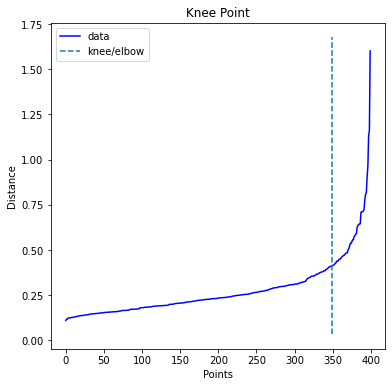

In [22]:
find_eps(X1, 8)

Optimal number of min_samples based on silhouette score: [12]


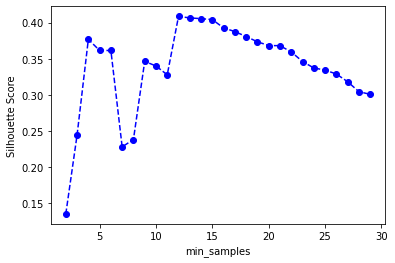

In [23]:
get_min_samples(X1, 0.412351792)

As indicated by the two plots above, the best radius is 0.412351792, and the best number of neighbors for this radius is 12. Now, we train our model with these parameters.

Silhouette Coefficient: 0.409


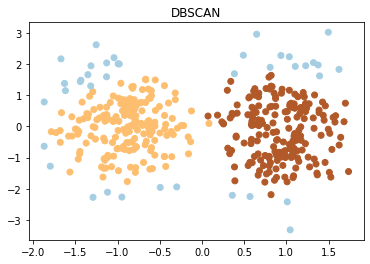

In [24]:
dbscan(X1, 0.412351792, 12)

As you can see, our data has been clustered, and with these parameters, we've also identified the outlier points. However, as you can observe, the DBSCAN algorithm did not perform clustering effectively, and K-means has worked better.

### FCM

the partition coefficient is: 0.372


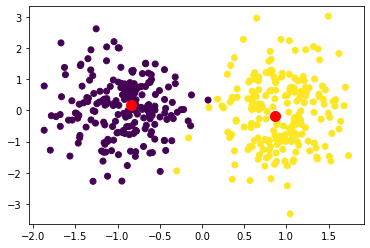

In [25]:
fcmCluster(X1, 2)

As you can see, this algorithm has also performed well and has divided the data into 2 clusters. The final coefficient is 0.372.

Now, we create a DataFrame and input the error values and coefficients for each algorithm. It's important to note that each algorithm is executed 200 times, and the best model is recorded.

In [26]:
df_result_err_dataset1 = pd.DataFrame()
df_result_err_dataset1.index = ['Kmeans', 'DBSCAN', 'fuzzy c-means']
# df_result_err.columns = ['wcss for Kmeans', 'Silhouette Coefficient for DBSCAN', 'partition coefficient for fcm']
df_result_err_dataset1

""
Kmeans
DBSCAN
fuzzy c-means


In [27]:
kmeans_err1 = run_200_kmeans_get_err(X1, 2)
print("the least error for kmeans: ", kmeans_err1)

the least error for kmeans:  452.60628960519114


In [28]:
dbscan_err1 = run_200_dbscan_get_err(X1, 0.412351792, 12)
print("the best silhouette score for dbscan: ", dbscan_err1)

the best silhouette score for dbscan:  0.4087436436572648


In [29]:
fcm_err1 = run_200_fcm_get_err(X1, 2)
print("the best partition coefficient for fcm: ", fcm_err1)

the best partition coefficient for fcm:  0.37244606299899813


In [30]:
df_result_err_dataset1['wcss for Kmeans'] = [kmeans_err1, 'nan', 'nan']
df_result_err_dataset1['Silhouette Coefficient for DBSCAN'] = ['nan', dbscan_err1, 'nan']
df_result_err_dataset1['partition coefficient for fcm'] = ['nan', 'nan', fcm_err1]

## Running 3 clustering algorithms for the second dataset

### Kmeans

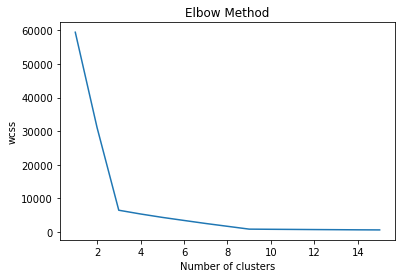

In [31]:
drawElbowMethodPlot(df2)

Using the `drawElbowMethodPlot` function, we determine that the best number for the cluster count is 3 and 9 because the plot breaks at those points. Now, we consider 9 as the cluster count.

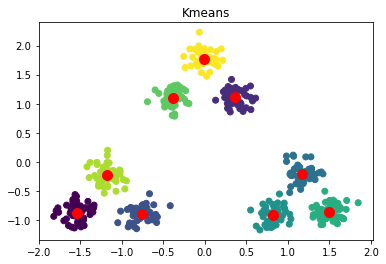

the SSE is:  13.35681054484629


In [32]:
kmeansAndPlot(9, X2)

We execute the `kmeansAndPlot` function, and you can see the display above. As you can observe, the data has been clustered effectively into 9 clusters, and the SSE (sum of squared errors) is equal to 13, which is a very good value. This indicates that we have designed a very strong model.

### DBSCAN

Below, we use two functions, `find_eps` and `get_min_samples`, to find the best parameters for DBSCAN. We then train the data with these parameters, and finally, assign a label to each point.

0.1779747000623319


<Figure size 360x360 with 0 Axes>

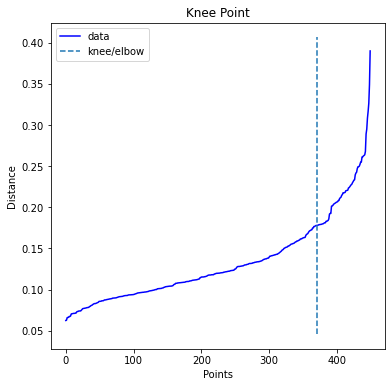

In [33]:
find_eps(X2, 12)

Optimal number of min_samples based on silhouette score: [6, 7]


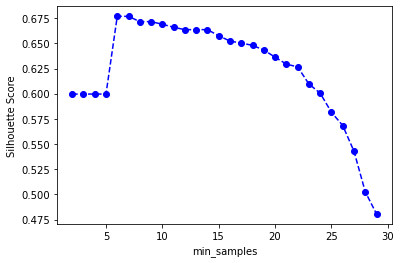

In [34]:
get_min_samples(X2, 0.17797470)

As shown by the two plots above, the best radius is 0.17797470, and the best number of neighbors for this radius is 6. Now, we train our model with these parameters.

Silhouette Coefficient: 0.677


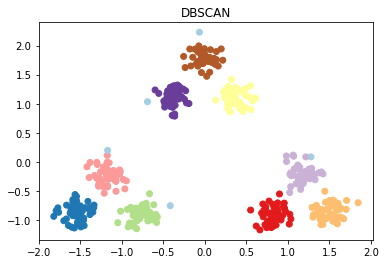

In [35]:
dbscan(X2, 0.17797470, 6)

As you can see, our data has been clustered into 9 clusters, and with these parameters, we've also identified the outlier points. The coefficient for this algorithm is 0.677, indicating a good model.

### FCM

the partition coefficient is: 0.089


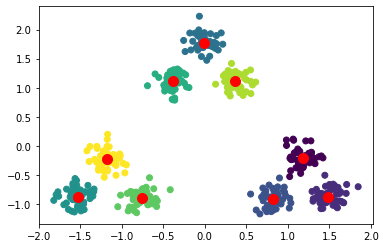

In [36]:
fcmCluster(X2, 9)

As you can see, this algorithm has also performed well and has divided the data into 9 categories. The final coefficient is 0.089.

Now, we are creating a data frame and entering the error values and coefficients for each algorithm. The point here is that each algorithm is executed 200 times, and the best model is selected.

In [37]:
df_result_err_dataset2 = pd.DataFrame()
df_result_err_dataset2.index = ['Kmeans', 'DBSCAN', 'fuzzy c-means']
# df_result_err.columns = ['wcss for Kmeans', 'Silhouette Coefficient for DBSCAN', 'partition coefficient for fcm']
df_result_err_dataset2

""
Kmeans
DBSCAN
fuzzy c-means


In [38]:
kmeans_err2 = run_200_kmeans_get_err(X2, 9)
print("the least error for kmeans: ", kmeans_err2)

the least error for kmeans:  13.35681054484629


In [39]:
dbscan_err2 = run_200_dbscan_get_err(X2, 0.17797470, 6)
print("the best silhouette score for dbscan: ", dbscan_err2)

the best silhouette score for dbscan:  0.6767810363064451


In [40]:
fcm_err2 = run_200_fcm_get_err(X2, 9)
print("the best partition coefficient for fcm: ", fcm_err2)

the best partition coefficient for fcm:  0.08894466498214497


In [41]:
df_result_err_dataset2['wcss for Kmeans'] = [kmeans_err2, 'nan', 'nan']
df_result_err_dataset2['Silhouette Coefficient for DBSCAN'] = ['nan', dbscan_err2, 'nan']
df_result_err_dataset2['partition coefficient for fcm'] = ['nan', 'nan', fcm_err2]

## Running 3 clustering algorithms for the third dataset

### Kmeans

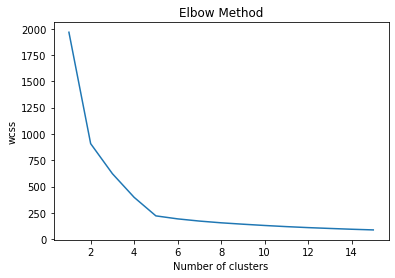

In [42]:
drawElbowMethodPlot(df3)

By using the `drawElbowMethodPlot` function, we can determine that the optimal number for the clusters is 5, as the plot breaks there.

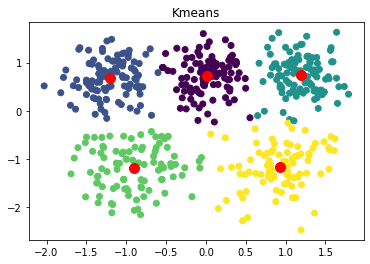

the SSE is:  127.41193957295542


In [43]:
kmeansAndPlot(5, X3)

We execute the `kmeansAndPlot` function, and you can see its display above. As you can see, the data has been clustered well into 5 categories, and the silhouette score is 0.127, which is a good value. It means we have designed a relatively good model.

### DBSCAN

Below, with two functions, `find_eps` and `get_min_samples`, we find the best parameters for DBSCAN and train the data with these parameters. Finally, we assign a label to each point.

0.32940758724179037


<Figure size 360x360 with 0 Axes>

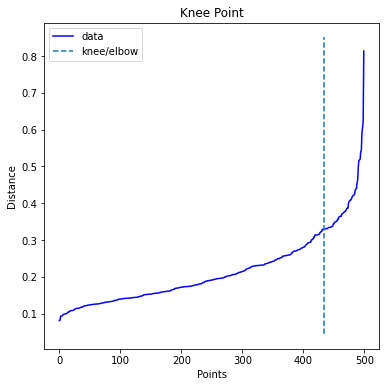

In [44]:
find_eps(X3, 8)

Optimal number of min_samples based on silhouette score: [14]


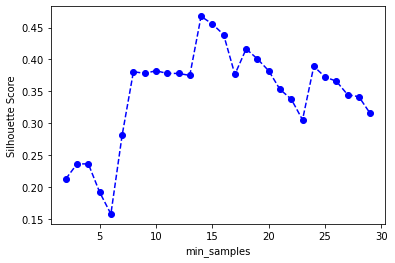

In [45]:
get_min_samples(X3, 0.3294075)

As shown in the two charts above, the best radius is 0.3294075, and the best number of neighbors within this radius is 14. Now, we train our model.

Silhouette Coefficient: 0.499


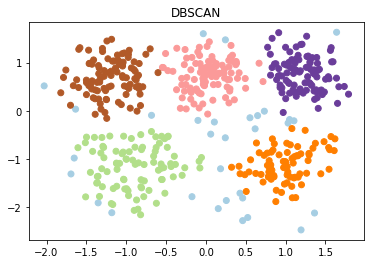

In [46]:
dbscan(X3, 0.3184, 14)

As you can see, our data has been clustered into 5 categories, and with these parameters, we have also identified the outlier points. The coefficient of this algorithm is 0.5, indicating a moderate model.

### FCM

the partition coefficient is: 0.136


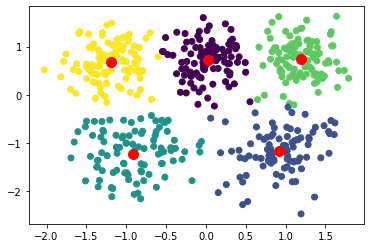

In [47]:
fcmCluster(X3, 5)

As you can see, this algorithm has also performed well and has divided the data into 5 categories. The final coefficient is also equal to 0.136.

Now, we are creating a DataFrame and entering the error values and coefficients for each algorithm. The point here is that each algorithm is executed 200 times, and the best model is selected.

In [48]:
df_result_err_dataset3 = pd.DataFrame()
df_result_err_dataset3.index = ['Kmeans', 'DBSCAN', 'fuzzy c-means']
# df_result_err.columns = ['wcss for Kmeans', 'Silhouette Coefficient for DBSCAN', 'partition coefficient for fcm']
df_result_err_dataset3

""
Kmeans
DBSCAN
fuzzy c-means


In [49]:
kmeans_err3 = run_200_kmeans_get_err(X3, 5)
print("the least error for kmeans: ", kmeans_err3)

the least error for kmeans:  127.41193957295542


In [50]:
dbscan_err3 = run_200_dbscan_get_err(X3, 0.3184, 14)
print("the best silhouette score for dbscan: ", dbscan_err3)

the best silhouette score for dbscan:  0.4985974286118582


In [51]:
fcm_err3 = run_200_fcm_get_err(X3, 5)
print("the best partition coefficient for fcm: ", fcm_err3)

the best partition coefficient for fcm:  0.13568331273125506


In [52]:
df_result_err_dataset3['wcss for Kmeans'] = [kmeans_err3, 'nan', 'nan']
df_result_err_dataset3['Silhouette Coefficient for DBSCAN'] = ['nan', dbscan_err3, 'nan']
df_result_err_dataset3['partition coefficient for fcm'] = ['nan', 'nan', fcm_err3]

## Displaying the DataFrame of errors and coefficients for each algorithm for the datasets.

### First dataset

In [53]:
df_result_err_dataset1

,wcss for Kmeans,Silhouette Coefficient for DBSCAN,partition coefficient for fcm
Kmeans,452.60629,nan,nan
DBSCAN,nan,0.408744,nan
fuzzy c-means,nan,nan,0.372446


### second dataset

In [54]:
df_result_err_dataset2

,wcss for Kmeans,Silhouette Coefficient for DBSCAN,partition coefficient for fcm
Kmeans,13.356811,nan,nan
DBSCAN,nan,0.676781,nan
fuzzy c-means,nan,nan,0.088945


As you can see, the K-means algorithm has shown the best performance. And the DBSCAN algorithm has performed better for this dataset compared to the other datasets

### third dataset

In [55]:
df_result_err_dataset3

,wcss for Kmeans,Silhouette Coefficient for DBSCAN,partition coefficient for fcm
Kmeans,127.41194,nan,nan
DBSCAN,nan,0.498597,nan
fuzzy c-means,nan,nan,0.135683


In this section as well, K-means has performed well as we have reached an error of 127.